# PyTorch Workflows

Let's explore a example of PyTorch end-end-workflow


In [1]:
import torch
import numpy as np
from torch import nn # contains all of pytorch building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__
device = "cuda" if torch.cuda.is_available () else "cpu"

In [2]:

what_we_cover = {1: "data (prepare adn load)",
                 2: "build a model",
                 3: "fitting the model to the data",
                 4: "making predictions and evaluating the model (inference)",
                 5: "saving and loading the model",
                 6: "Assembly"}


what_we_cover

{1: 'data (prepare adn load)',
 2: 'build a model',
 3: 'fitting the model to the data',
 4: 'making predictions and evaluating the model (inference)',
 5: 'saving and loading the model',
 6: 'Assembly'}

## Data (preparing and loading)

Data can be almost anything in ML:

* Excel spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

Machine Learning (ML) is a game of 2 parts:
1. Get data into numerical representation
2. Build a model to learn patterns in numerical representation

Let's create some known data using the linear regression formulae

Use of linear regression formulae to form a straight line with known **parameters**

In [3]:
# create a *known* parameters

weight = 0.7
bias = 0.3

# Create data

start = 0
end  = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Split data into training and test sets (super significant)

1. Training set `-->` equivalent to the course material provided by a lecturer (always needed)
2. Validation set `-->` equivalent to the course exercise provided by a lecturer (often not always needed)
3. Test set `-->` equivalent to the final examination provided by a lecturer (always needed)

In [5]:
# create a training-test split of the data

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How to betetr vizualize our data?

"Vizualize, Vizualize, Vizualize!"

In [6]:
def plot_predictions(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):

    """
    Plots training data, test data, and compares predictions
    """
    plt.figure(figsize=(10,7))

    #plot training data in blue

    plt.scatter(train_data, train_labels, c='b', s=4, label="Training Data")

    # plot test data in green

    plt.scatter(test_data, test_labels, c='g', s=4, label="Test Data")

    #Are there predictions

    if predictions is not None:
        #plot the predictions if they exist
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
    
    # show legends
    plt.legend(prop={'size':14});

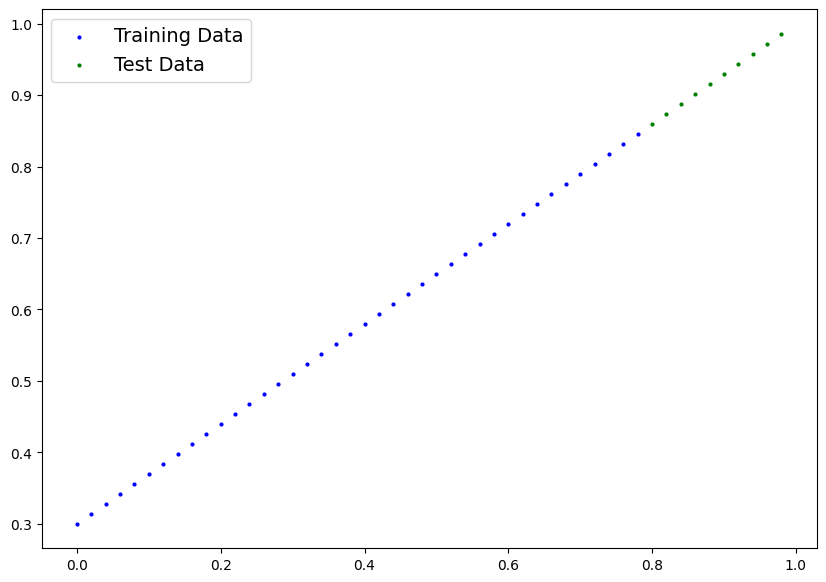

In [7]:
plot_predictions()

## Building our first PyTorch Model

What our model does:

* Start with random values (weight and bias)
* Look at training data and adjust random values to represent idea values for weight and bias

How does it work using algorithms:

1. Uses gradient descent
2. Backpropagation



### PyTorch Model Essentials

* `torch.nn` - contains all of the building blocks for computational graphs (neural network in this case)
* `torch.nn.parameter` - what paramaters should our model try and learn, often a PyTorch Layer from torch.nn will set it for us
* `torch.nn.Module` - base class for all NN modules, if subclassed the forward should be overwritten
* `torch.optim` - where optimizer in PyTorch live, assissting with gradient descent
* `def forward()` all nn.Module subclasses require you to overwrite `forward()`, this method defines the forward computations

In [8]:
# use pure pytorch top create linear regresseion model class

class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1,                           # start with a random weight and try to adjust it to an ideal weight
                                                requires_grad = True,       # executes the gradient descent algorithm in the background
                                                dtype=torch.float))         # Adjust to PyTorch float32

        self.bias = nn.Parameter(torch.randn(1,                             # start with a random bias and try to adjust it to an ideal bias
                                            requires_grad=True,
                                            dtype=torch.float))
    # forward() defines the computation in the model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias                                  # this is the linear regression model

### Checking the contents of the PyTorch Model

Investuigate the contents of a PyTorch module using `.parameters()`.

In [9]:
torch.manual_seed(42)

# create an instance of the model

model_0 = LinearRegressionModel()

# investigate the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# list the names parameters

model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Make a prediction using `torch.inference_mode()`

To check the models predictive power, let's see how well is predicts 'y' based on 'x'

When we pass data through our model, its going to run the forward() method

In [11]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds, y_test

(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

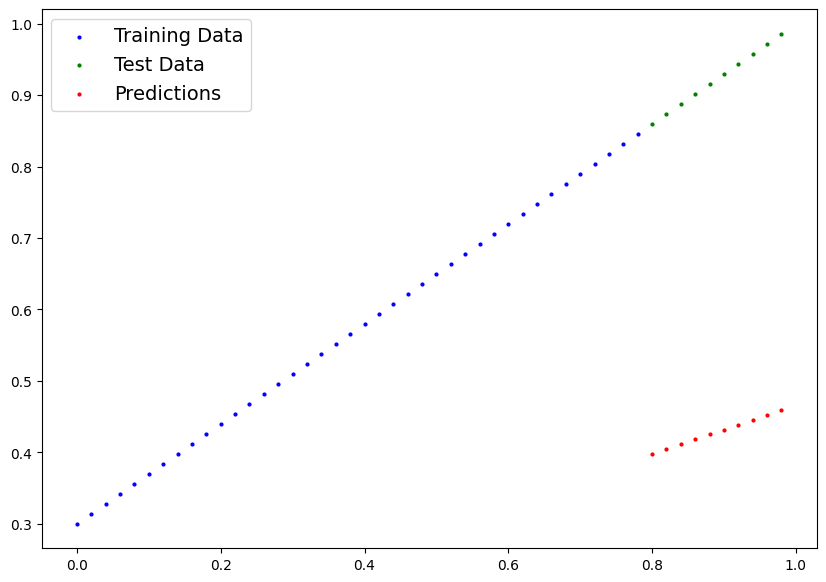

In [12]:
plot_predictions(predictions=y_preds)

## Training Model

The whole idea of training is for the model to move from some *unknown* parameters (these must be random) to some *known* parameters

One way to measure the quality of the prediction of the model is to use a loss function

* Note: Loss or cost fucntioin or criterion (usually refer to as loss function)

Things that need training:

* **Loss fucntion:** A fucntion to measure how wrong the models predictions are to the ideal outputs --> lower is better
* **Optimizer:** A fucntion which takes into account the loss of a model and adjusts the parameters (eg. weight and bias)

Specifically for PyTorch:

* A training loop
* A testing loop

In [13]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [14]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Implementing Loss Functions and Optimizers

* Use of Mean Absolute Error (MAE) - calculate the absolute difference between each of the points and calculate mean thereof
* Use of Stochastic Gradient Descent (SGD) - optimize the weights based on the loss function
* Params (`model_0.parameters`) is an argument that is needed for the optimizer and is retrieved from the model that's created
* lr = learning rate --> possibly most important hyperparameter

In [15]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer function
optimizer = torch.optim.SGD(model_0.parameters(),   
                            lr=0.01)                

## Building a Training and Testing Loop in PyTorch

A couple of steps are needed:

1. Loop through the data
2. Forward pass: this involves data moving through the models forward fucntion(s) - a.k.a forward propagation
3. Calculate the Loss: Compare the forward pass predictions to ground truth labels
4. Optimnizer zero grad'
5. Loss backward: move backwards through network to calculate gradient of gradients of each parameter with respect to lost (**backpropagation**)
6. Optimizer step: use optimizer to adjust the models parameters to try and improve loss (**gradient descent**)



In [16]:
torch.manual_seed(42)
# An epoch is 1 loop through the data - hyperparameter set by ourselves
epochs = 1


# 1. Loop through the data
for epoch in range(epochs):
    # set the model to training mode (multiple modes)
    model_0.train()     # train mode in PyTorch sets all parameters that requires gradients require gradients
    
    # 2. Forward pass
    y_pred = model_0(X_train)

    # 3. Calculate loss
    loss = loss_fn(y_pred,y_train)
    print(f"Loss: {loss}")

    # 4. Optimizer zero grad
    optimizer.zero_grad()

    # 5. Perform backpropagation on the loss with respect to the parameters of the models
    loss.backward()

    # 6. Step the optimizer (perform gradient descent)
    optimizer.step()    # by default how the optimizer changes will calculate through the loop .. we have to zerothem above in step 4


model_0.eval()      # turns off gradient tracking

print(model_0.state_dict())    

Loss: 0.31288138031959534
OrderedDict({'weight': tensor([0.3406]), 'bias': tensor([0.1388])})


In [17]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

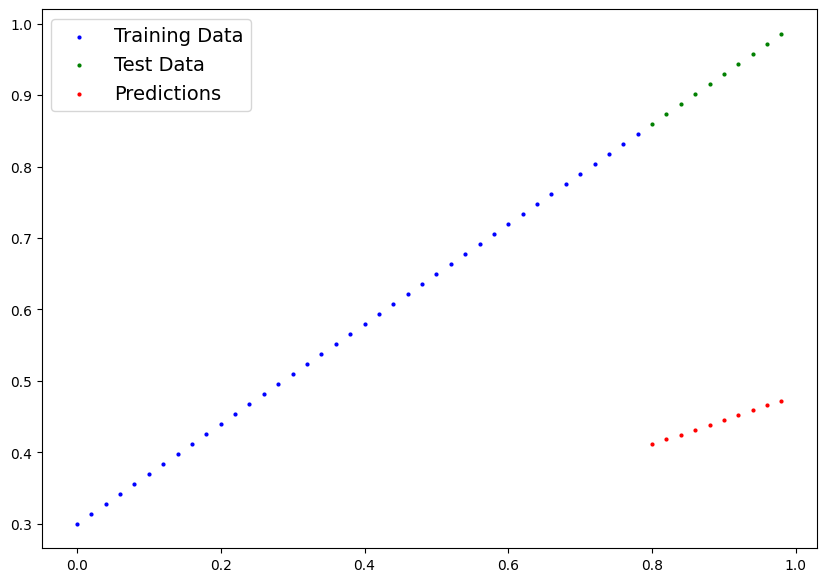

In [18]:
plot_predictions(predictions=y_preds_new)

Epoch: 0 | Test Loss: 0.4675942063331604 | Loss 0.3013603389263153
OrderedDict({'weight': tensor([0.3445]), 'bias': tensor([0.1488])})
Epoch: 10 | Test Loss: 0.3328842222690582 | Loss 0.18615034222602844
OrderedDict({'weight': tensor([0.3835]), 'bias': tensor([0.2488])})
Epoch: 20 | Test Loss: 0.2069590985774994 | Loss 0.08227583020925522
OrderedDict({'weight': tensor([0.4222]), 'bias': tensor([0.3403])})
Epoch: 30 | Test Loss: 0.14023718237876892 | Loss 0.05181945487856865
OrderedDict({'weight': tensor([0.4539]), 'bias': tensor([0.3788])})
Epoch: 40 | Test Loss: 0.11182951927185059 | Loss 0.04503796249628067
OrderedDict({'weight': tensor([0.4768]), 'bias': tensor([0.3868])})
Epoch: 50 | Test Loss: 0.09809747338294983 | Loss 0.04132963344454765
OrderedDict({'weight': tensor([0.4956]), 'bias': tensor([0.3838])})
Epoch: 60 | Test Loss: 0.08776430785655975 | Loss 0.03785243630409241
OrderedDict({'weight': tensor([0.5134]), 'bias': tensor([0.3783])})
Epoch: 70 | Test Loss: 0.07949176430702

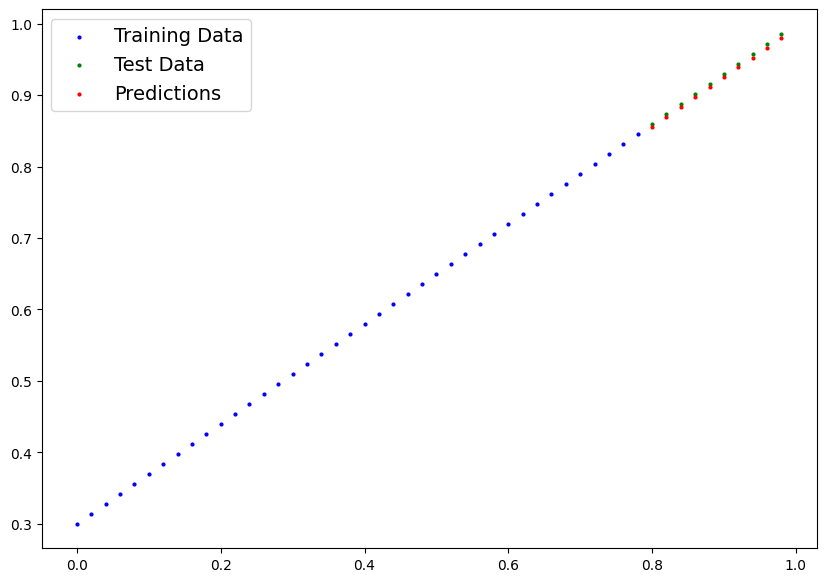

In [19]:
# redo the previous code to generate the model using 100 epochs instead

torch.manual_seed(42)
epoch_count = []
loss_values = []
test_loss_count = []

epochs_new = 200
# training model
for epoch_new in range(epochs_new):
    model_0.train()
    y_preds_2 = model_0(X_train)
    loss = loss_fn(y_preds_2,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_0.eval()  # turns off different settings in the model not needed for evaluations (dropout/ batchnorm layers)

    # testing the model
    with torch.inference_mode():    # turns off gradient tracking
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)
    if epoch_new % 10 ==0:
        epoch_count.append(epoch_new)
        loss_values.append(loss)
        test_loss_count.append(test_loss)
        print(f"Epoch: {epoch_new} | Test Loss: {test_loss} | Loss {loss}")
        print(model_0.state_dict())
plot_predictions(predictions=test_pred)

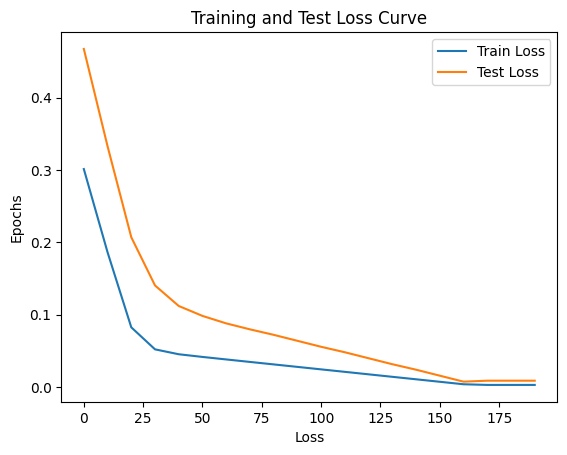

In [20]:
# Plot the loss curves for both the training and the test curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_count, label="Test Loss")
plt.title("Training and Test Loss Curve")
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.legend()


## Saving a model in PyTorch

3 main methods for saving and loading models in PyTorch:
1. `torch.save()` - allows you to save torch object in Pythons pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows you to load a models saved state dictionary

In [21]:
# save the entire model using torch.save()
from pathlib import Path


# 1. create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)


# 2. create model save path
MODEL_NAME = "01_pythorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

# 3. Save the model State Dict - recommended way of saving models in python
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), 
           f=MODEL_SAVE_PATH)


Saving model to: models\01_pythorch_workflow_model_0.pth


## Loading a PyTorch Model

Since we saved our models `state_dict()` rather than the entire model, we will need to create a new instance of the model class and load the `state_dict()` into that.

In [22]:
# Loading a model by instantiating a new model class

loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict() of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

C:\Users\kebrown\AppData\Local\Temp\ipykernel_13040\780432286.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH

<All keys matched successfully>

In [23]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [24]:
# Make some prediction to ensure that the loaded model is running correctly
torch.manual_seed(42)
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8554],
        [0.8693],
        [0.8832],
        [0.8971],
        [0.9110],
        [0.9249],
        [0.9388],
        [0.9527],
        [0.9666],
        [0.9805]])

In [25]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.8554],
        [0.8693],
        [0.8832],
        [0.8971],
        [0.9110],
        [0.9249],
        [0.9388],
        [0.9527],
        [0.9666],
        [0.9805]])

In [26]:
# Compare the loaded model preds with the original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Putting it all together



In [27]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check torch version
torch.__version__


'2.5.1+cu121'

In [28]:
# Create device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"

## Data


In [29]:
# Create some data using linear regression formula of y = weight * X + bias

weight = 0.7
bias = 0.3

# create a range of features

start = 0
end = 1
step = 0.02

# Create X and y features (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

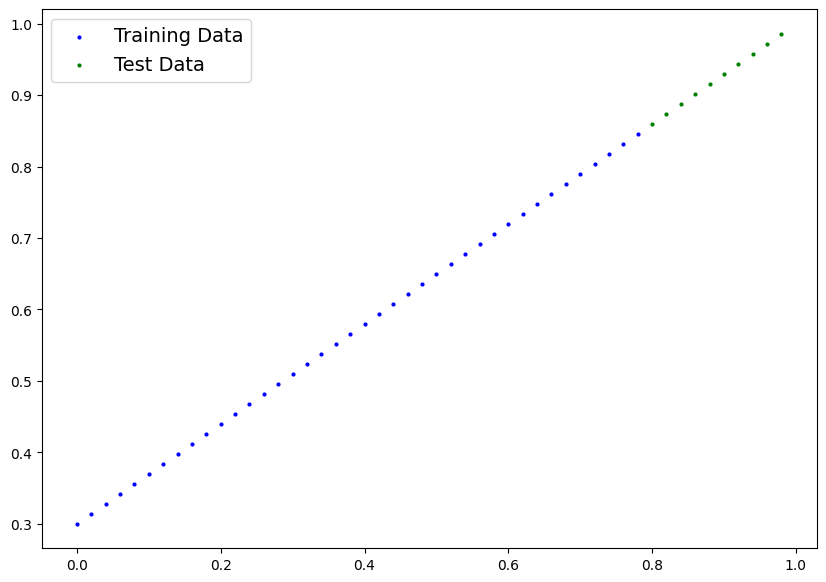

In [30]:
# Split the data

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

plot_predictions(X_train, y_train, X_test, y_test)

## Building a PyTorch Linear Model

In [31]:
# create a linear model by subclassing the nn.Module class

class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear for creating the model parameters/ also known as linear transformation, probing layer
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(142)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.8555]])),
              ('linear_layer.bias', tensor([-0.2062]))]))

In [32]:
# check the model current device

next(model_1.parameters()).device

device(type='cpu')

In [33]:
# Set the model to use the taregt device
model_1.to(device)
next(model_1.parameters()).device


device(type='cuda', index=0)

### Training

For training we need:
* Loss Function - measure how wrong model is
* Optimizer - optimizes weights and biases
* Training Loop
* Test Loop

In [34]:
# Setup loss function

loss_fn = nn.L1Loss() # same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.01,)

# write a training loop
torch.manual_seed(42)
epochs = 200

# Ensure that thhe data is on the cuda device as well

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_preds = model_1(X_test)
        test_loss = loss_fn(test_preds, y_test)

    # Print out what's happening

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Test Loss: {test_loss} | Loss: {loss}")

Epoch: 0 | Test Loss: 0.35428568720817566 | Loss: 0.44550758600234985
Epoch: 10 | Test Loss: 0.21957574784755707 | Loss: 0.3302975594997406
Epoch: 20 | Test Loss: 0.08486583083868027 | Loss: 0.2150876373052597
Epoch: 30 | Test Loss: 0.04815880209207535 | Loss: 0.10024497658014297
Epoch: 40 | Test Loss: 0.10720194876194 | Loss: 0.06254564225673676
Epoch: 50 | Test Loss: 0.11994602531194687 | Loss: 0.05600264295935631
Epoch: 60 | Test Loss: 0.11788230389356613 | Loss: 0.052246399223804474
Epoch: 70 | Test Loss: 0.11304429918527603 | Loss: 0.04872751235961914
Epoch: 80 | Test Loss: 0.10545871406793594 | Loss: 0.04528982192277908
Epoch: 90 | Test Loss: 0.09718620777130127 | Loss: 0.04186138138175011
Epoch: 100 | Test Loss: 0.08891373127698898 | Loss: 0.03842388466000557
Epoch: 110 | Test Loss: 0.08132816851139069 | Loss: 0.03498787805438042
Epoch: 120 | Test Loss: 0.0730556845664978 | Loss: 0.031559061259031296
Epoch: 130 | Test Loss: 0.06478320062160492 | Loss: 0.02812025509774685
Epoch: 

In [35]:
model_1.state_dict()


OrderedDict([('linear_layer.weight', tensor([[0.7202]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2913], device='cuda:0'))])

### Making and evaluating predictions

In [36]:
# Turn the model into evaluation mode

model_1.eval()

# Make some predicitons using the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8675],
        [0.8819],
        [0.8963],
        [0.9107],
        [0.9251],
        [0.9396],
        [0.9540],
        [0.9684],
        [0.9828],
        [0.9972]], device='cuda:0')

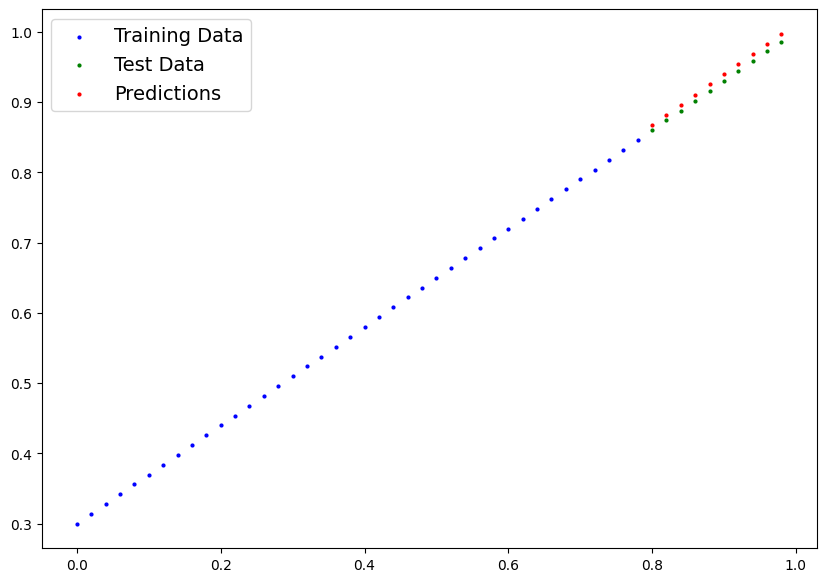

In [37]:
# Check out the model predictions visually
plot_predictions(predictions=y_preds.cpu())

### Saving and loading a trained model

In [38]:
from pathlib import Path

# 1. Create a model directory

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_1.pth


In [39]:
# Load a PyTorch Model

# Create a new instance of Linear Regression model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved state dict of model_1
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put the loaded model to the same device
loaded_model_1.to(device)

C:\Users\kebrown\AppData\Local\Temp\ipykernel_13040\72488891.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [40]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [41]:
# Evaluate the loaded model

loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_1(X_test)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')